# Assignment 0

In [2]:
import pandas as pd
import numpy as np
from numpy import linalg as LNG
from sklearn.decomposition import PCA
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm, ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

np.random.seed(42)

# Supress deprecation warnings
import warnings
warnings.filterwarnings('error', category=DeprecationWarning) 

/Users/nastaran/anaconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/nastaran/anaconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/nastaran/anaconda3/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDepr

In [ ]:
# Training inputs (image as vector)
X_train = pd.read_csv("data/train_in.csv", header=None).to_numpy()

# Training outputs (number that each vector represents)
Y_train = pd.read_csv("data/train_out.csv", header=None).to_numpy()

X_test = pd.read_csv("data/test_in.csv", header=None).to_numpy()
Y_test = pd.read_csv("data/test_out.csv", header=None).to_numpy()

## Calculating the center for each cloud c_d

In [ ]:
def get_digit_cloud(X, Y, digit):
    # Finding all the indexes from Y_train_out related to digit
    d_indices = np.where(Y == digit)[0]

    # an array of all images related to the current d
    return X[d_indices]

In [ ]:
# Stores calculated centers
# Label corresponds to index, eg. Center_0 = clouds[0]
cloud_centers = []

for d in range(10):
    cloud_d = get_digit_cloud(X_train, Y_train, d)

    # Calculating the mean/center of each cloud
    center_d = np.mean(cloud_d, axis=0)

    # add each mean vector to clouds
    cloud_centers.append(center_d)

## Calculating center distances for each digit/label

In [ ]:
distances_matrix = np.full((10,10), np.NaN)

for row_index in range(0,10):
    for column_index in range(0,10):
        if column_index == row_index or not np.isnan(distances_matrix[column_index, row_index]):
            continue

        c1 = cloud_centers[row_index]
        c2 = cloud_centers[column_index]
        
        distances_matrix[row_index, column_index] = LNG.norm(c1 - c2)

In [ ]:
pd.DataFrame(distances_matrix)

## Dimensionality Reduction

In [ ]:
def visualize(X, Y, title):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='Set1', s=5)
    plt.colorbar()
    plt.title(title)
    plt.show()

def visualize_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", square=True)
    plt.title("Confusion Matrix (Count)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()

### PCA

In [ ]:
# Initiaze PCA
pca = PCA(n_components=2, random_state=42)

# Fit PCA to data
clouds_PCA = pca.fit_transform(X_train)

#show data
visualize(clouds_PCA, Y_train, "PCA of 256 Dimensional Data")
    

### U-MAP

In [ ]:
# initialize UMAP
umap_reducer = umap.UMAP(random_state=42)

# Fit UMAP model to data
clouds_umap = umap_reducer.fit_transform(X_train)

# show data
visualize(clouds_umap, Y_train, "UMAP Projection of 256 Dimensional Data")

### T-SNE

In [ ]:
#Initialize T-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42)

# Fit TSNE model to data
cloud_tsne = tsne.fit_transform(X_train)

#show data
visualize(cloud_tsne, Y_train, "T-SNE of 256 dimensional space")


### Define Nearest Mean Classifier

In [ ]:
def nearest_mean_classifier(new_vectors):
    Y_predict = []

    for v in new_vectors:
        distances_to_clouds = [LNG.norm(v-center) for center in cloud_centers]

        # Returns the label for the first closest cloud
        Y_predict.append(np.argmin(distances_to_clouds))
    return Y_predict

### Train K-Nearest-Neighbor Classifier

In [ ]:
knn = KNeighborsClassifier(41)
knn.fit(X_train, np.ravel(Y_train))

## Testing NearestMeanClassifier & KNearestNeighborClassifier accuracy

In [ ]:
def get_accuracy(X, Y, classifier):
    correct = 0

    Y_predict = classifier(X)

    for y_predict, y in zip(Y_predict, Y):
        if y_predict == y:
            correct+=1
     
    accuracy_score(Y, Y_predict)
    return round(correct / X.shape[0] * 100, 2)

# def get_accuracy(X, Y, classifier):
#     return round(accuracy_score(Y, classifier(X)) * 100, 2)


### Accurracy on training set

In [ ]:
nm_acc = get_accuracy(X_train, Y_train, nearest_mean_classifier)
print(f'Nearest Mean accuracy on training set: {nm_acc}%')

knn_acc = get_accuracy(X_train, Y_train, knn.predict)
print(f'KNN accuracy on training set: {knn_acc}%')

### Accurracy on test set

In [ ]:
nm_acc = get_accuracy(X_test, Y_test, nearest_mean_classifier)
print(f'Nearest Mean accuracy on test set: {nm_acc}%')

knn_acc = get_accuracy(X_test, Y_test, knn.predict)
print(f'KNN accuracy on test set: {knn_acc}%')

### Confusion Matrix

In [ ]:
Y_predict_nmc = nearest_mean_classifier(X_train)
Y_predict_knn = knn.predict(X_train)
Y_test_predict_nmc = nearest_mean_classifier(X_test)
Y_test_predict_knn = knn.predict(X_test)

confusion_matrix_nmc = confusion_matrix(Y_train, Y_predict_nmc)
confusion_matrix_nmc_test = confusion_matrix(Y_test, Y_test_predict_nmc)

confusion_matrix_knn = confusion_matrix(Y_train, Y_predict_knn)
confusion_matrix_knn_test = confusion_matrix(Y_test, Y_test_predict_knn)

print(f'Nearest Mean confusion matrix on the train sets')
visualize_confusion_matrix(confusion_matrix_nmc)
print(f'Nearest Mean confusion matrix on the test sets')
visualize_confusion_matrix(confusion_matrix_nmc_test)

print(f'KNN confusion matrix on the train sets')
visualize_confusion_matrix(confusion_matrix_knn)
print(f'KNN confusion matrix on the test sets')
visualize_confusion_matrix(confusion_matrix_knn_test)


![](delta-rule1.png)

In [ ]:
# slide page 13 lecture 2
# sigmoid function: ϕ(x)=1/(1+exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ϕ(x)=1/(1+exp(-x)) we have: ϕʹ(x)=ϕ(x)(1-ϕ(x))=output(1-output)
# so once we know ϕ(x) we also know ϕʹ(x) !
def sigmoid_derivative(x):
    return x * (1 - x)

# initialize random weights, multiply by 0.01 to get small values for improving learning rate
weights = np.random.randn(257, 10) * 0.1


def perceptron(input, labels, alpha, epochs):
    np.random.seed(42) 
    w = weights
    for epoch in range(epochs):
        for key in range(input.shape[0]):
            output = np.dot(input[key], w)
            output_sigmoid = sigmoid(output)

            target = np.zeros(10)
            target[labels[key]] = 1

            error = sigmoid_derivative(
                output_sigmoid) * (target - output_sigmoid)

            # update weights
            w = w + alpha * np.outer(input[key], error)

        if epoch % 10 == 0:
            # Compute accuracy for training set
            output_training = np.dot(input, w)
            predictions = np.argmax(sigmoid(output_training), axis=1)
            accuracy = np.mean(predictions == labels)
            print(f"Epoch {epoch}, Training Set Accuracy: {accuracy}")

            # Compute accuracy for test set
            output_test = np.dot(np.hstack([X_test, np.ones((X_test.shape[0], 1))]), w)
            predictions = np.argmax(sigmoid(output_test), axis=1)
            accuracy = np.mean(predictions == Y_test.flatten())
            print(f"Epoch {epoch}, Test Set Accuracy: {accuracy} \n****************************************")

alpha = 0.01
epochs = 100

perceptron(
    # add bias to input
    np.hstack([X_train, np.ones((X_train.shape[0], 1))]),
    Y_train.flatten(),
    alpha,
    epochs
)


# Task 3

In [ ]:
class Layer:
    def __init__(self, input_size, output_size, debug=False) -> None:
        self.weights = np.random.uniform(-1,1,(input_size, output_size))
        self.biases = np.ones((1,output_size))  # Initialize biases
        self.debug = debug

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)
    
    def activate(self, Z):
        return np.apply_along_axis(self.sigmoid, 0, Z)

    def forward(self, input_data):
        self.inputs = input_data
        # z
        self.z = np.dot(input_data, self.weights) + self.biases
        # a
        self.output = self.activate(self.z)
        return self.output

    def backward(self, d_error):
        # TODO
        d_activation = sigmoid_derivative(self.output)


In [ ]:
X_train = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
])

Y_train = np.array([
    0,
    1,
    1,
    0
])

# Network architecture
input_size = 2
hidden_size = 2
output_size = 1

# Hyperparameters
learning_rate = 0.01
epochs = 100 * 100

#initialize weights and biases
#layer 1 
w1 = np.random.uniform(-1,1,(input_size, hidden_size))
b1 = np.zeros((1,hidden_size))
#layer2
w2 = np.random.uniform(-1,1,(hidden_size, output_size))
b2 = np.zeros((1, output_size))

#Training loop
for epoch in range(epochs):
    # First layer output
    z1 = np.dot(X_train, w1) + b1

    # Apply sigmoid activation
    a1 = 1 / (1 + np.exp(-z1))

    # Second layer ouput
    z2 = np.dot(a1, w2) + b2

    #Apply sigmoid activation
    a2 = 1 / (1 + np.exp(-z2))

    # Calculate loss (MSE)
    loss = np.mean((a2 - Y_train)**2)

    #Backward pass
    d_mse = 2 * (a2 - Y_train[:, np.newaxis])

    d_a2 = a2 * (1 - a2)
    d_z2 = a1
    
    d_w2 = np.dot(d_z2.T, d_mse * d_a2)
    d_b2 = np.sum(d_mse * d_a2, axis=0, keepdims=True)

    d_a1 = a1 * (1 - a1)
    d_z1 = X_train
    
    d_w1 = np.dot(d_z1.T, np.dot(d_mse * d_a2, w2.T) * d_a1)
    d_b1 = np.sum(np.dot(d_mse * d_a2, w2.T) * d_a1, axis=0, keepdims=True)

    # Update weights and biases
    w1 -= learning_rate * d_w1
    b1 -= learning_rate * d_b1
    w2 -= learning_rate * d_w2
    b2 -= learning_rate * d_b2

    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

In [ ]:
X = np.array([0,0])

# First layer output
z1 = np.dot(X, w1) + b1

# Apply sigmoid activation
a1 = 1 / (1 + np.exp(-z1))

# Second layer ouput
z2 = np.dot(a1, w2) + b2

a2 = 1 / (1 + np.exp(-z2))
a2

Epoch: 100, Loss: 0.18190276644098227


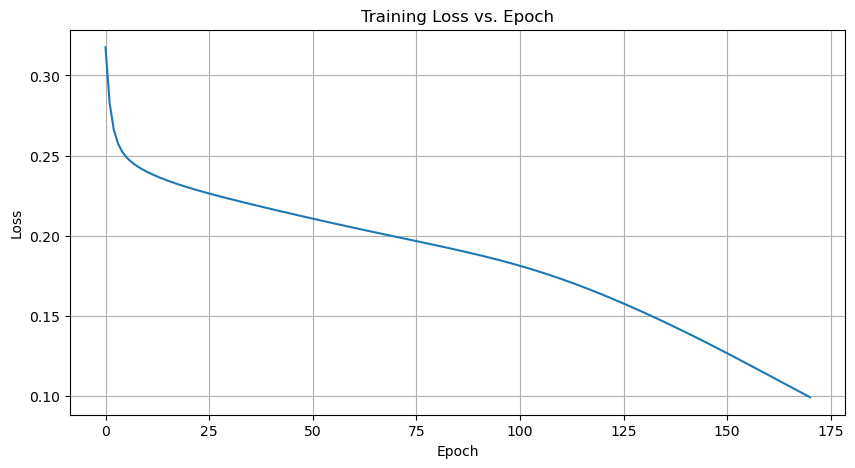


Predictions
Input: [0 0], True Label: 0, Predicted: 0
Input: [0 1], True Label: 1, Predicted: 1
Input: [1 0], True Label: 1, Predicted: 1
Input: [1 1], True Label: 0, Predicted: 0


1.0

In [58]:
Y_train = np.array([
    [0],
    [1],
    [1],
    [0]
])

X_train = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
])

def mse(Y_pred, Y_true):
    return np.mean(np.square(Y_pred - Y_true))

# Hyperbolic Tangent
def tanh_activation(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1.0 - a**2
    
def predict(w1, w2, b1, b2):
        z1 = np.dot(X_train, w1) + b1
        a1 = tanh_activation(z1)
        z2 = np.dot(a1, w2) + b2
        a2 = tanh_activation(z2)

        return z1, a1, z2, a2

def unpack_weights(weights):
    w1 = weights[:4].reshape(2, 2)
    b1 = weights[4:6].reshape(1, 2)
    w2 = weights[6:8].reshape(2, 1)
    b2 = weights[8].reshape(1, 1)
    return w1, b1, w2, b2

def grdmse(weights, epochs=1000, alpha=0.1, max_loss = 0.1):
    
    epoch = 0
    loss = 1

    losses = []
    while epoch < epochs and loss > max_loss:
        w1, b1, w2, b2 = unpack_weights(weights)
        # Feedforward
        z1, a1, z2, a2 = predict(w1, w2, b1, b2)

        # Compute Loss
        loss =  mse(a2, Y_train)
        losses.append(loss)

        # Backpropagation
        dJ_da2 = a2 - Y_train
        da2_dz2 = tanh_derivative(a2)
        dz2_dw2 = a1
        dJ_dw2 = np.dot(dz2_dw2.T, dJ_da2 * da2_dz2)

        dz2_da1 = w2

        dJ_da1 = np.dot(dJ_da2 * da2_dz2, dz2_da1.T)
        dJ_dw1 = np.dot(X_train.T, dJ_da1 * tanh_derivative(a1))

        w1 -= alpha * dJ_dw1
        w2 -= alpha * dJ_dw2
        b1 -= alpha * np.sum(dJ_da1 * tanh_derivative(a1), axis=0)
        b2 -= alpha * np.sum(dJ_da2 * da2_dz2, axis=0)

        epoch += 1
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')

    return w1, b1, w2, b2, losses


weights = np.random.uniform(-1, 1, (9))

w1, b1, w2, b2, losses = grdmse(weights)

plt.figure(figsize=(10,5))
plt.plot(losses)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Predictions
print("\nPredictions")
for x, y in zip(X_train, Y_train):
    z1 = np.dot(x, w1) + b1
    a1 = tanh_activation(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = tanh_activation(z2)
    print(f"Input: {x}, True Label: {y[0]}, Predicted: {round(a2[0][0])}")

z1, a1, z2, a2 = predict(w1, w2, b1, b2)
Y_pred = np.where(a2 < 0.5, 0, 1)
accuracy_score(Y_train, Y_pred)